In [ ]:
# source:http://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction

Notes:
    1. the data file has one column is a time series
    2. when preparing the training set, you use every 50 data points to predict the next one.
       So use a window of size 51 scan the time series and get a (x,y) pair every step. 
    3. After you get the training_input, you need to expand its dimension to (num_samples, time_steps, input_dim)
       (time_steps = 50, input_dim =1)
    4. The model you use is one layer of LSTM model, cell_hidden_state = 

How normalization works:
        we will take each n-sized window of training/testing data and normalize each one to 
        reflect percentage changes from the start of that window (so the data at point i=0 
        will always be 0). We’ll use the following equations to normalise and subsequently de-normalise at 
        the end of the prediction process to get a real world number out of the prediction:
            
        n = normalised list [window] of price changes
        p = raw list [window] of adjusted daily return prices
    Normalization:
        n_i = (p_i/p_0) - 1
    De-normalization:
        p_i = p_0(n_i+1)
        

Clarify 
１. 如果你要stack up two LSTM layers, 你必须用return_sequence = True，否则只返回the last timestep 
得到的输出值（这个输出值即一个LSTM cell的hidden state经过transform的结果，可以是个sequence）

2. 对于一维时间序列，training data 应是[batch_size, time_steps,1]，而不是[batch_size,1,seq_len] 
(seq_len == time_steps),后一种设置，说明没有feedback进入（如果stateful＝False），
就是cell_state和hidden_state永远是你设定的初始值。(准备training data时，你用一个个window cut出input，其实是个２d矩阵，要扩展一个维度（第三维度）
np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

3. 对于２中的情况，输入的input_dim为１，那么输出的维度可以大于１吗，答案是可以。
这就是你设定的LSTM cell的hidden state的维度，这个输出可以stack到下一层LSTM layer。如果只有一层，那么最后一个time step的输出，经过wx+b的transform就是你要的输出，


In [6]:
import numpy as np
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

In [13]:
def load_data(filename, seq_len, normalise_window):
    f = open('./data/'+filename, 'rb').read()
    data = f.decode().split('\n')[:-1]

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [data,x_train, y_train, x_test, y_test]



def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [14]:
filename = 'sp500.csv'
seq_len = 50
normalise_window = True

In [15]:
data,X_train, y_train, X_test, y_test = load_data(filename, seq_len, True)
print 'X_train shape: (time steps is 50, input_dim is 1) ', X_train.shape

X_train shape: (time steps is 50, input_dim is 1)  (3708, 50, 1)


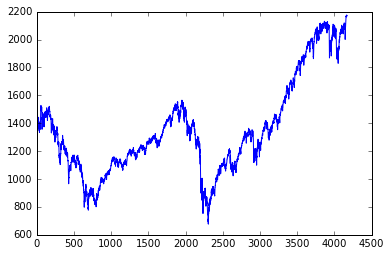

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
y= data
plt.plot(range(len(y)),y)

In [24]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim= 1,
        output_dim=60 ,
        return_sequences=False))

    model.add(Dense(
        output_dim= 1))
    model.add(Activation("linear"))


    model.compile(loss="mse", optimizer="rmsprop")
    print("Compiling model")
    return model

In [25]:
model = build_model([1, 50, 100, 1])

Compiling model


In [26]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=5,
    validation_split=0.05)


Train on 3522 samples, validate on 186 samples
Epoch 1/5
3522/3522 [==============================] - 3s - loss: 0.0028 - val_loss: 8.7501e-04
Epoch 2/5
3522/3522 [==============================] - 2s - loss: 6.5136e-04 - val_loss: 4.7618e-04

In [27]:
from numpy import newaxis
y_te_pred = model.predict(X_test)

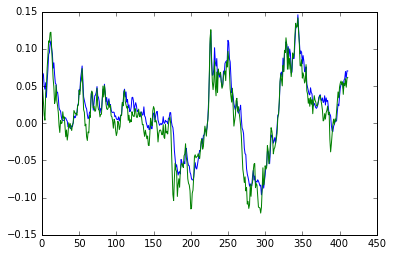

In [28]:
import matplotlib.pyplot as plt
plt.plot(range(len(y_test)),y_te_pred)
plt.plot(range(len(y_test)),y_test)
plt.show()

In [30]:
#A two-layer model:

def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ")
    return model


model = build_model([1, 50, 100, 1])


> Compilation Time : 
